## Wrapped normal mixture for all curvatures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay

from geomstats.visualization import plot as gplot
from geomstats.geometry.hypersphere import Hypersphere

from hyperdt.tree import HyperbolicDecisionTreeClassifier
from hyperdt.visualization import plot_tree, plot_boundary
from hyperdt.QC_wrapped_normal_all_curvatures import wrapped_normal_all_curvature

INFO: Using numpy backend


### Gaussian mixture in Euclidean space

In [3]:
# Generate Gaussian mixture data in Euclidean space
X, y = wrapped_normal_all_curvature(num_points=1000, num_classes=4, noise_std=0.3, seed=2, curvature=0.0)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

# Predict test set labels
y_pred = dtc.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


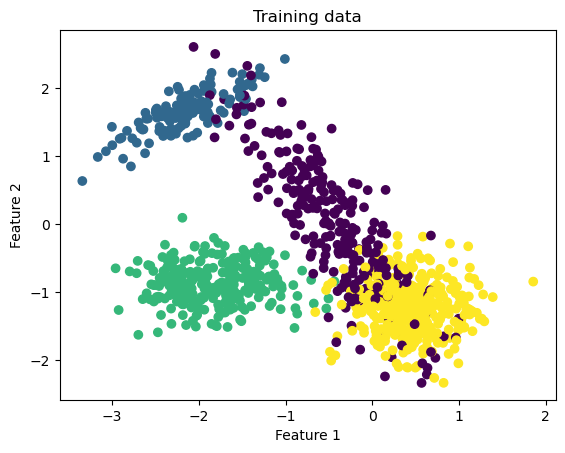

In [4]:
# Plot data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training data')
plt.show()

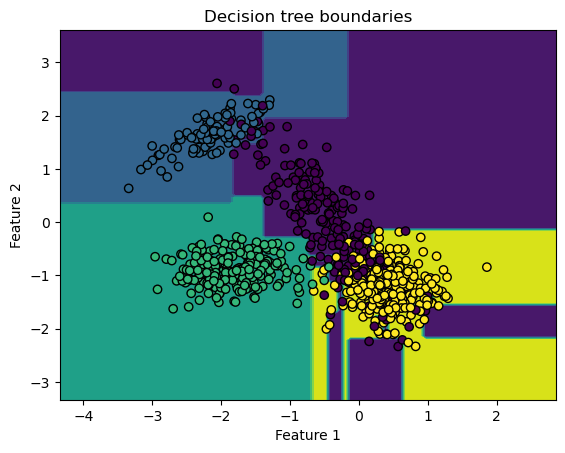

In [5]:
# Plot decision tree boundaries with training data
fig, ax = plt.subplots()
dbd = DecisionBoundaryDisplay.from_estimator(dtc, X_train, ax=ax)
dbd.plot(ax=ax)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision tree boundaries')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolor='k')
plt.show()

### Gaussian mixture in hyperbolic space

In [21]:
# Generate Gaussian mixture data in hyperbolic space
hyperbolic_curvature = -2.0
X, y = wrapped_normal_all_curvature(num_points=1000, num_classes=4, noise_std=0.3, seed=2, curvature=hyperbolic_curvature)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit hyperbolic decision tree classifier
hdt = HyperbolicDecisionTreeClassifier(timelike_dim=0, max_depth=2, curvature=hyperbolic_curvature)
hdt.fit(X_train, y_train)

# Compute accuracy
hdt_score = hdt.score(X_test, y_test)
print(hdt_score)

0.755


ValueError: Points do not belong to the hyperbolic space.

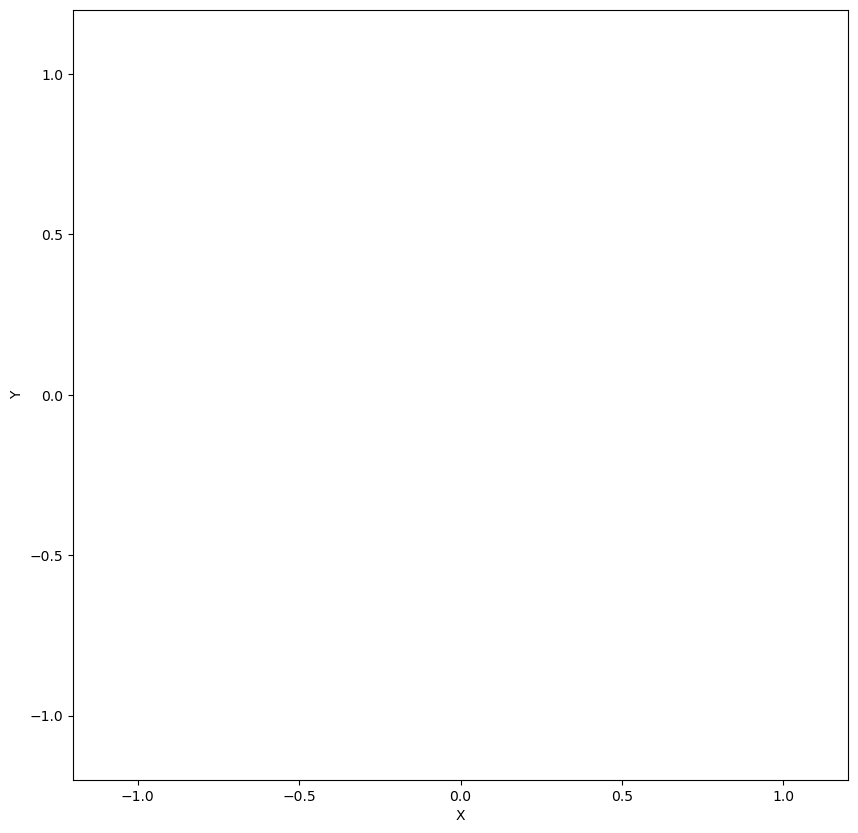

In [22]:
# Plot data and decision boundary
fig, ax = plt.subplots(figsize=(10, 10))
ax = gplot(X, c=y, space="H2_poincare_disk")
ax = plot_boundary(hdt.tree.feature, hdt.tree.theta, ax=ax)
plt.show()

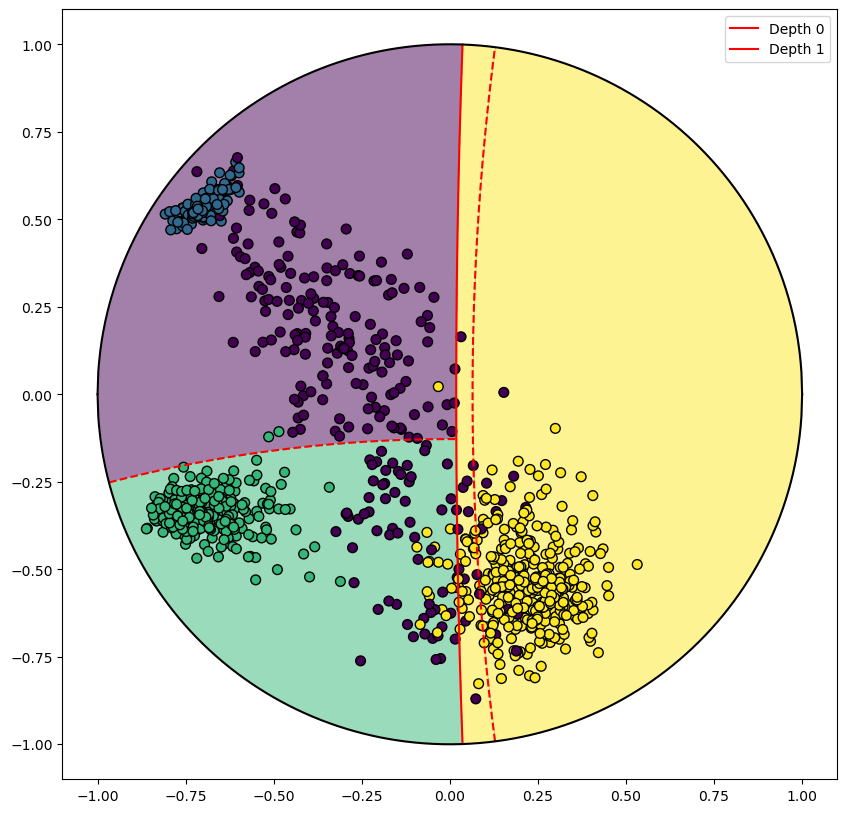

In [16]:
# Plot decision tree boundaries recursively
plot_tree(hdt, X=X, y=y)
plt.show()

### Gaussian mixture in hyperspherical space

In [23]:
# Modified decision tree classifier for hypersphere data
class HypersphereDecisionTreeClassifier(HyperbolicDecisionTreeClassifier):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _validate_hyperbolic(self, X):
        # Basically just skip the check
        pass

    def _get_candidates(self, X, dim):
        # Consider tangents
        thetas = np.arctan2(X[:, self.timelike_dim], X[:, dim])
        thetas = np.unique(thetas)  # This also sorts
        candidates = (thetas[:-1] + thetas[1:]) / 2
        return candidates

In [25]:
# Generate Gaussian mixture data in hyperspherical space
sphere_curvature = 2.0
X, y = wrapped_normal_all_curvature(num_points=1000, num_classes=4, noise_std=0.3, seed=2, curvature=sphere_curvature)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit hyperbolic decision tree classifier
hsdt = HypersphereDecisionTreeClassifier(max_depth=2, curvature=sphere_curvature)
hsdt.fit(X_train, y_train)

# Compute accuracy
hsdt_score = hsdt.score(X_test, y_test)
print(hsdt_score)

0.725


ValueError: Points do not belong to the sphere.

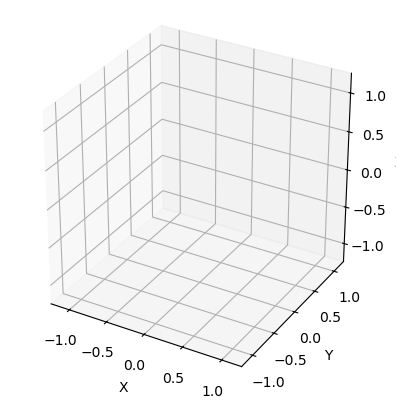

In [26]:
# Plot data in 3D
gplot(X, space="S2", marker="o", s=10, alpha=0.5, c=y)

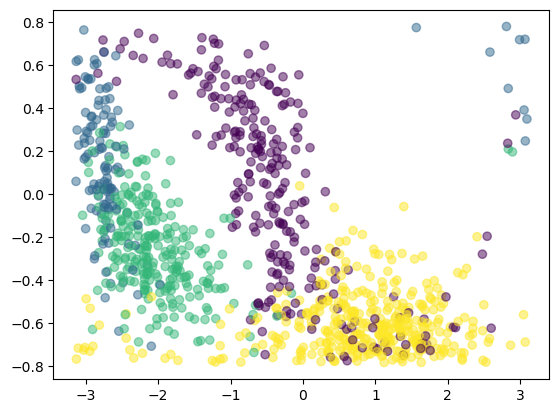

In [27]:
# Perform Mercator projection from 3D to 2D
def mercator_projection(points):
    """
    Perform Mercator projection from 3D to 2D for coordinates on a unit sphere.
    Assumes x, y, and z are NumPy arrays and ||x|| = 1.
    """

    # Calculate latitude (phi)
    phi = np.arcsin(points[:, 2])

    # Calculate longitude (lambda)
    lambda_ = np.arctan2(points[:, 1], points[:, 0])

    return np.stack([lambda_, phi], axis=1)


points_2d = mercator_projection(X)

plt.scatter(points_2d[:, 0], points_2d[:, 1], c=y, alpha=0.5)